** **
**Import required Libraries**








In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
import splitfolders  # or import split_folders
import os
import random
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score 


Mount Google *Drive* to upload Data

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')
     

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip -q '/flower_photos.zip'

Data Loading & Test-Train Splitting

In [ ]:
#Path of data set
input_folder = '/content/flower_photos' 

#Split the data into train, val, test with the ratio of 0.7,0.2,0.1
splitfolders.ratio(input_folder, output='/content/drive/MyDrive/flowers',  seed=42, ratio=(.8, .2), 
                   group_prefix=None) # default values

In [6]:
#Give the path of training data
#Get Classes
train_path = '/content/drive/MyDrive/flowers/train'  #path of training dataset
training_names = os.listdir(train_path) #read Training data
print(training_names) #classes in training Data
print(len(training_names)) #No. of classes in training data
# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = [] #paths of all training images
image_classes = [] #class ids of images
class_id = 0
#get a list of all the file paths to images in a training dataset
#complete path to ecah image
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)] #join class folder path with image path

#Fill the placeholder empty lists with image path, classes, and add class ID number 
for training_name in training_names:
    dir = os.path.join(train_path, training_name) #Path of each class folder
    class_path = imglist(dir) #Path of images in eac
    image_paths+=class_path #paths of all images
    image_classes+=[class_id]*len(class_path) #assign a number to images of each class 
    class_id+=1

['daisy', 'sunflowers', 'dandelion', 'tulips', 'roses']
5


In [7]:
# Create feature extraction and keypoint detector objects
# Create List where all the descriptors will be stored
des_list = []


sift = cv2.SIFT_create(40)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

#kmeans works only on float, so convert integers to float
descriptors_float = descriptors.astype(float)  


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

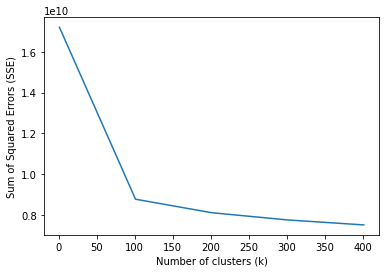

In [27]:
#find optimal number of clusters using elbow method
def OptClusters(descriptors_float,N):
    from sklearn.cluster import KMeans
    sse = {}
    for k in range(1, N ,100):
        km = KMeans(n_clusters=k, max_iter=1000).fit(descriptors_float)
        sse[k] = km.inertia_
    
    # Plot SSE against k
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Sum of Squared Errors (SSE)")
    plt.show()
OptClusters(descriptors_float,500)

In [8]:
# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 100  #k means with 100 clusters is the elbow point
voc, variance = kmeans(descriptors_float, k, 1) #voc is cluster centre

In [9]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(image_paths), k), "float32")  # Initialize an empty numpy array to store the histogram of visual word occurrences for each image
for i in range(len(image_paths)):  # Loop through each image in the dataset
    words, distance = vq(des_list[i][1],voc)  # Quantize the descriptors of the current image using the visual vocabulary
    for w in words:  # Loop through the visual words in the quantized descriptor array
        im_features[i][w] += 1  # Increment the corresponding bin in the histogram of visual word occurrences

# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)



In [11]:
########################################
# Define a range of possible values for gamma, C, and kernel
from sklearn.model_selection import GridSearchCV
from sklearn import svm
gamma_range = [0.1, 1, 10]
C_range = [0.1, 1, 10]
kernel_range = ['linear', 'rbf', 'poly','sigmoid']
# Define the SVM classifier
clf_svm = svm.SVC()

# Define the hyperparameter grid to search over
param_grid = {'gamma': gamma_range, 'C': C_range, 'kernel': kernel_range}
# Perform grid search cross-validation to select the best hyperparameters
grid_search = GridSearchCV(clf_svm, param_grid, cv=5)
grid_search.fit(im_features, np.array(image_classes))
# Print the best hyperparameter values and the corresponding cross-validation score
print("Best gamma:", grid_search.best_params_['gamma'])
print("Best C:", grid_search.best_params_['C'])
print("Best kernel:", grid_search.best_params_['kernel'])
print("Best cross-validation score:", grid_search.best_score_)
###########################################################
from sklearn.svm import SVC
# train the SVM classifier with best hyperparameters
svm_best = SVC(C=grid_search.best_params_['C'],
               kernel=grid_search.best_params_['kernel'],
               gamma=grid_search.best_params_['gamma'])
svm_best.fit(im_features, np.array(image_classes))

Best gamma: 0.1
Best C: 1
Best kernel: linear
Best cross-validation score: 0.45228994540412


SVC(C=1, gamma=0.1, kernel='linear')

In [12]:
##############################################################
#Train Random forest to compare how it does against SVM
from sklearn.ensemble import RandomForestClassifier
#clf_rf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf_rf.fit(im_features, np.array(image_classes))

# create random forest classifier
clf_rf = RandomForestClassifier()

# specify hyperparameters to tune and their possible values
param_grid = {
    'n_estimators': [100, 200,300,400, 500],
    'max_depth': [10, 20,30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# use GridSearchCV to search for best hyperparameters
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(im_features, np.array(image_classes))


# print best hyperparameters and their score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
############################################
# train the random forest classifier with best hyperparameters
rf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                   max_depth=grid_search.best_params_['max_depth'],
                                   min_samples_split=grid_search.best_params_['min_samples_split'],
                                   min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                   bootstrap=grid_search.best_params_['bootstrap'])
rf_best.fit(im_features, np.array(image_classes))

Best hyperparameters:  {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Best score:  0.4730730096342251


RandomForestClassifier(max_depth=40, min_samples_split=5, n_estimators=400)

In [13]:
# Save the model
#Joblib dumps Python object into one file

joblib.dump((svm_best, training_names, stdSlr, k, voc), "bovw_svm_flowers.pkl", compress=3)    
joblib.dump((rf_best, training_names, stdSlr, k, voc), "bovw_rf_flowers.pkl", compress=3)    


['bovw_rf_flowers.pkl']

In [14]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf_svm, classes_names_svm, stdSlr_svm, k_svm, voc_svm = joblib.load("bovw_svm_flowers.pkl")
clf_rf , classes_names_rf , stdSlr_rf , k_rf , voc_rf = joblib.load("bovw_rf_flowers.pkl")

In [17]:
# Get the path of the testing image(s) and store them in a list
test_path =  '/content/drive/MyDrive/flowers/val'   # Folder Names are Parasitized and Uninfected
#instead of test if you use train then we get great accuracy
testing_names = os.listdir(test_path)
# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number

for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1


In [18]:
des_list = []

sift = cv2.SIFT_create(40)

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

# Calculate the histogram of features
#vq Assigns codes from a code book to observations.
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [19]:
# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

true_class =['daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy

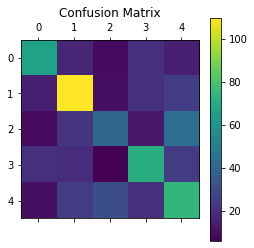

F1 score for SVM: 0.49062257263983455
              precision    recall  f1-score   support

       daisy       0.55      0.52      0.53       127
   dandelion       0.57      0.61      0.59       180
       roses       0.42      0.32      0.36       129
  sunflowers       0.49      0.51      0.50       140
      tulips       0.41      0.47      0.44       160

    accuracy                           0.49       736
   macro avg       0.49      0.48      0.49       736
weighted avg       0.49      0.49      0.49       736



In [23]:
#Report true class names so they can be compared with predicted classes
true_class =  [classes_names_svm[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions_svm =  [classes_names_svm[i] for i in clf_svm.predict(test_features)]


#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions_svm))

###############################################
#To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion Matrix')
    pl.colorbar()
    pl.show()


accuracy_svm = accuracy_score(true_class, predictions_svm)
print ("accuracy = ", accuracy_svm)
cm_svm = confusion_matrix(true_class, predictions_svm)
print (cm_svm)

showconfusionmatrix(cm_svm)
###############################################################################
#Calculate F1 score
from sklearn.metrics import f1_score

f1_svm = f1_score(true_class, predictions_svm, average='weighted')
print("F1 score for SVM:", f1_svm)

#Print classification report
from sklearn.metrics import classification_report

report_svm = classification_report(true_class, predictions_svm)
print(report_svm)

true_class =['daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy

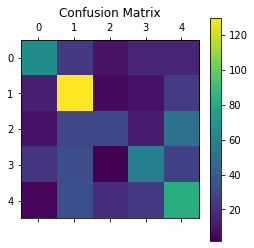

F1 score for RF: 0.4818876672103903
              precision    recall  f1-score   support

       daisy       0.58      0.51      0.54       127
   dandelion       0.53      0.72      0.61       180
       roses       0.47      0.23      0.31       129
  sunflowers       0.50      0.41      0.45       140
      tulips       0.41      0.51      0.46       160

    accuracy                           0.49       736
   macro avg       0.50      0.48      0.47       736
weighted avg       0.50      0.49      0.48       736



In [26]:
#Report true class names so they can be compared with predicted classes
true_class =  [classes_names_rf[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions_rf=  [classes_names_rf[i] for i in clf_rf.predict(test_features)]


#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions_rf))

###############################################
#To make it easy to understand the accuracy let us print the confusion matrix

def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion Matrix')
    pl.colorbar()
    pl.show()


accuracy_rf = accuracy_score(true_class, predictions_rf)
print ("accuracy = ", accuracy_rf)
cm_rf = confusion_matrix(true_class, predictions_rf)
print (cm_rf)

showconfusionmatrix(cm_rf)
###############################################################################
#Calculate F1 score
from sklearn.metrics import f1_score

f1_rf= f1_score(true_class, predictions_rf, average='weighted')
print("F1 score for RF:", f1_rf)

#Print classification report
from sklearn.metrics import classification_report

report_rf = classification_report(true_class, predictions_rf)
print(report_rf)